In [1]:
import pandas as pd
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
import numpy as np
from numpy import array

import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
from statsmodels.formula.api import ols

import scipy
from scipy import stats,interpolate
from scipy.stats import skew,kurtosis,describe,variation,shapiro
from scipy.special import kl_div
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

import optuna
from optuna.integration import XGBoostPruningCallback
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import GridSearchCV,cross_validate
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression,LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, KFold 
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier,IsolationForest,StackingClassifier,GradientBoostingRegressor,AdaBoostRegressor,RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,classification_report,confusion_matrix
from mlxtend.regressor import StackingRegressor,StackingCVRegressor
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,MinMaxScaler,RobustScaler,Binarizer

from lightgbm import LGBMClassifier,LGBMRegressor
from xgboost import XGBClassifier,XGBRegressor

from imblearn.under_sampling import RandomUnderSampler

import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
def mse(y,pred):
    return mean_squared_error(y,pred)

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def MAPE(y,pred):
    return np.mean(np.abs((y-pred)/y)*100)    

def SMAPE(y, pred):
    return np.mean((np.abs(y-pred))/(np.abs(y) + np.abs(pred)))

def evaluate_regr(y,pred): # 종합 평가지표 
    mse_val = mse(y,pred)
    rmse_val = rmse(y,pred)
    mae_val = mean_absolute_error(y,pred)
    mape_val = np.mean(np.abs((y-pred)/y)*100)
    smape_val = 100 / len(y) * np.sum(np.abs(pred - y) / (np.abs(y) + np.abs(pred)))
    print("MSE:{0:4F},RMSE:{1:4f},MAE:{2:4F},MAPE:{3:4F},SMAPE:{4:4F}".format(mse_val,rmse_val,mae_val,mape_val,smape_val))

In [3]:
def get_eval_by_threshold(y_test,pred_proba_c1,thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값',custom_threshold)
        get_clf_eval(y_test,custom_predict,pred_proba_c1)
        print('\n')

In [4]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [5]:
#### one hot 적용해보기 

In [6]:
LoadData = pd.read_csv('train.csv').head()
LoadData

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


#### Y-Class
- 0 : 적정 기준 미달 
- 1 : 적합
- 2 : 적정 기준 초과 

In [7]:
#### Train Data
data = pd.read_csv('train.csv')
data = data.drop(['Y_Quality'],axis=1) 

data_copy = data.copy()
data_copy['Y_Class'] = data_copy['Y_Class'].replace({0:1, 2:1, 1:0})

#data_object = data.select_dtypes(include='object')
#data_inputs = data.select_dtypes(include=[int,float]).fillna(data.select_dtypes(include=[int,float]).mean()).dropna(axis=1)
#data_inputs = data.select_dtypes(include=[int,float]).fillna(0) 

data = data.fillna(0)

#data = pd.concat([data_object,data_inputs],axis=1)
ids = data.nunique().values>1 # 획일값 제거 
data = data.loc[:,ids]

# 적정기준 미달 & 적정기준 초과 통합 
data['Y_Class'] = data['Y_Class'].replace({0:1, 2:1, 1:0})
print(data.shape)

(598, 2599)


#### Target Y_Class = Classification 기준 변수 선택 

In [8]:
def TrainTest_FillNA_Stat():

    Data = data_copy[data.columns]
    Target = 'Y_Class' # 예측변수 Y 

    Input_Data = Data.select_dtypes(include=[int,float]).drop([Target],axis=1) # 입력변수 X 
    Input_Data = Input_Data.loc[:,Input_Data.nunique().values>1] # 획일값 제거 

    X = Input_Data
    y = Data['Y_Class']

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=2021)

    X_train = X_train.select_dtypes(include=[int,float]).fillna(data.select_dtypes(include=[int,float]).mean()).dropna(axis=1)
    X_test = X_test.select_dtypes(include=[int,float]).fillna(data.select_dtypes(include=[int,float]).mean()).dropna(axis=1)

    Train = pd.concat([X_train,y_train],axis=1)
    Pass = Train[Train['Y_Class']==0].drop(['Y_Class'],axis=1)
    Fail = Train[Train['Y_Class']==1].drop(['Y_Class'],axis=1)

    T_Test = stats.ttest_ind(Pass,Fail,equal_var=False) # equal_var=True
    Columns = pd.DataFrame(X_train.columns).rename(columns={0:'Columns'})
    P_Value = pd.DataFrame(T_Test[1]).rename(columns={0:'P-Value'})
    Concat_columns_pvalues = pd.concat([Columns,P_Value],axis=1).dropna()

    Significant_Values = Concat_columns_pvalues[Concat_columns_pvalues['P-Value'] < 0.05]['Columns'].to_list()

    return Significant_Values


Significant_Values  = TrainTest_FillNA_Stat()# Y_Class Target Train Data 한정 T-Test P-Value < 0.05 수준에서 유의한 변수 선택 

#### Regression Target 재업로드 

In [9]:
data_reg = pd.read_csv('train.csv')
Target_Class = data_reg['Y_Class']
data_reg = data_reg.drop(['Y_Class'],axis=1) 

X = data_reg[Significant_Values]
y = data_reg['Y_Quality']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=2021)
X_train = X_train.select_dtypes(include=[int,float]).fillna(data.select_dtypes(include=[int,float]).mean()).dropna(axis=1)
X_test = X_test.select_dtypes(include=[int,float]).fillna(data.select_dtypes(include=[int,float]).mean()).dropna(axis=1)


y_test_class = train_test_split(X,Target_Class ,test_size=0.1,random_state=2021)[3]

In [10]:
X_train.shape,X_test.shape

((538, 2215), (60, 2215))

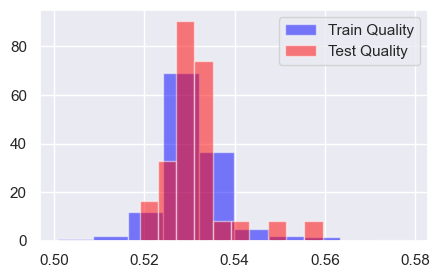

In [11]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

sns.set(font_scale=1.0)
plt.figure(figsize=(5,3))
plt.grid(True)
plt.hist(y_train,density=True,label='Train Quality',color='blue',alpha=0.5)
plt.hist(y_test,density=True,label='Test Quality',color='red',alpha=0.5)
plt.legend()

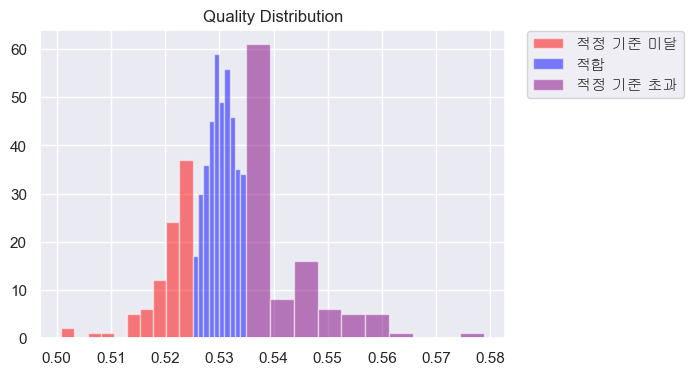

,Y_Quality
Y_Class,
0,0.520837
1,0.530253
2,0.542031


In [12]:
#한글폰트 적용
data_originalTarget = pd.read_csv('train.csv')
data_originalTarget = data_originalTarget[['Y_Quality','Y_Class']]

sns.set(font_scale=1.0)
plt.figure(figsize=(6,4))
plt.grid(True)
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)
plt.title('Quality Distribution')
plt.hist(data_originalTarget[data_originalTarget['Y_Class']==0]['Y_Quality'],label='적정 기준 미달',color='red',alpha=0.5)
plt.hist(data_originalTarget[data_originalTarget['Y_Class']==1]['Y_Quality'],label = '적합',color='blue',alpha=0.5)
plt.hist(data_originalTarget[data_originalTarget['Y_Class']==2]['Y_Quality'],label = '적정 기준 초과',color='purple',alpha=0.5)
plt.legend(bbox_to_anchor=(1.4, 1.02))
plt.show()

data_originalTarget.groupby('Y_Class').mean()

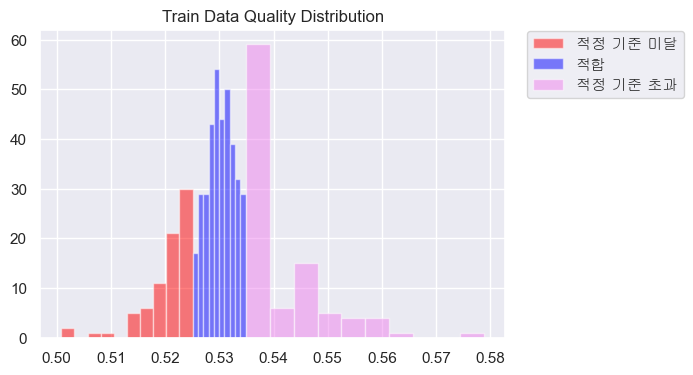

,Y_Quality
Y_Class,
0,0.520552
1,0.530199
2,0.541715


In [13]:
#한글폰트 적용
Train_Double_Targets = pd.concat([y_train,Target_Class.iloc[y_train.index]],axis=1)

sns.set(font_scale=1.0)
plt.figure(figsize=(6,4))
plt.grid(True)
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)
plt.title('Train Data Quality Distribution')
plt.hist(Train_Double_Targets[Train_Double_Targets['Y_Class']==0]['Y_Quality'],label='적정 기준 미달',color='red',alpha=0.5)
plt.hist(Train_Double_Targets[Train_Double_Targets['Y_Class']==1]['Y_Quality'],label = '적합',color='blue',alpha=0.5)
plt.hist(Train_Double_Targets[Train_Double_Targets['Y_Class']==2]['Y_Quality'],label = '적정 기준 초과',color='violet',alpha=0.5)
plt.legend(bbox_to_anchor=(1.4, 1.02))
plt.show()

Train_Double_Targets.groupby('Y_Class').mean()

#### ML 

In [14]:
# 활용할 ML 나열 
rf = RandomForestRegressor(random_state=2021)
ada = AdaBoostRegressor(random_state=2021,n_estimators=30)
gbm = GradientBoostingRegressor(random_state=2021)
xgb = XGBRegressor(random_state=2021)
lgbm =  LGBMRegressor(random_state=2021)

models = [rf,ada,gbm,xgb,lgbm]

In [15]:
def test_ml(model):
    
    ml = model
    ml.fit(X_train,y_train)      
    pred = ml.predict(X_test)
    print('----------------------------------------------------------------------------------------------------------')
    print(evaluate_regr(y_test,pred))
    
    if model == rf:
        print('RandomForest Prediction Result')
        print('\n')
        
    elif model == ada:
        print('AdaBoost Prediction Result')
        print('\n')
     
    elif model == gbm:
        print('GradientBoostingMachine Prediction Result')
        print('\n')
        
    elif model == xgb:
        print('XGBoost Prediction Result')
        print('\n')
        
    elif model == lgbm:
        print('LightGBM Prediction')
        print('\n')   

In [16]:
# 전체 모델  원큐 출력 
for i in range(0,len(models)):

    model = models[i]
    test_ml(model) 

----------------------------------------------------------------------------------------------------------
MSE:0.000021,RMSE:0.004531,MAE:0.003518,MAPE:0.662111,SMAPE:0.330823
None
RandomForest Prediction Result


----------------------------------------------------------------------------------------------------------
MSE:0.000029,RMSE:0.005399,MAE:0.004257,MAPE:0.799040,SMAPE:0.399235
None
AdaBoost Prediction Result


----------------------------------------------------------------------------------------------------------
MSE:0.000020,RMSE:0.004511,MAE:0.003439,MAPE:0.646438,SMAPE:0.322988
None
GradientBoostingMachine Prediction Result


----------------------------------------------------------------------------------------------------------
MSE:0.000020,RMSE:0.004468,MAE:0.003121,MAPE:0.587261,SMAPE:0.292983
None
XGBoost Prediction Result


----------------------------------------------------------------------------------------------------------
MSE:0.000030,RMSE:0.005480,MAE:0.00

#### Regression

In [17]:
#X_train_log = np.log1p(X_train)
#X_test_log = np.log1p(X_test)

#scaler = StandardScaler()
#scaler.fit(X_train) # Train Data 기준으로 Train/Test 스케일링 진행 

#X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns = X_train.columns)
#X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)

In [18]:
# 활용할 LR 나열 
lr = LinearRegression()
ridge = Ridge(alpha=100.0,random_state=2021)
lasso = Lasso(alpha=100.0,random_state=2021)
elasticnet = ElasticNet(alpha=10.0, l1_ratio=1.0,random_state=2021)

regs = [lr,ridge,lasso,elasticnet]

In [19]:
def test_reg(model):
    
    ml = model
    ml.fit(X_train,y_train)      
    pred = ml.predict(X_test)
    print('----------------------------------------------------------------------------------------------------------')
    print(evaluate_regr(y_test,pred))
    
    if model == lr:
        print('Linear Regression Prediction Result')
        print('\n')
        
    elif model == ridge:
        print('Ridge Regression  Prediction Result')
        print('\n')
     
    elif model == lasso:
        print('Lasso Regression Prediction Result')
        print('\n')
        
    elif model == elasticnet:
        print('ElasticNet Regression Prediction Result')
        print('\n')

In [20]:
# 전체 모델  원큐 출력 
for i in range(0,len(regs)):

    model = regs[i]
    test_reg(model) # Input_Data, df_ttest, df_L1Penalty

----------------------------------------------------------------------------------------------------------
MSE:0.000133,RMSE:0.011527,MAE:0.009175,MAPE:1.726524,SMAPE:0.863147
None
Linear Regression Prediction Result


----------------------------------------------------------------------------------------------------------
MSE:0.000069,RMSE:0.008318,MAE:0.005146,MAPE:0.961124,SMAPE:0.482224
None
Ridge Regression  Prediction Result


----------------------------------------------------------------------------------------------------------
MSE:0.000054,RMSE:0.007369,MAE:0.004772,MAPE:0.890796,SMAPE:0.447332
None
Lasso Regression Prediction Result


----------------------------------------------------------------------------------------------------------
MSE:0.000053,RMSE:0.007273,MAE:0.004762,MAPE:0.889070,SMAPE:0.446343
None
ElasticNet Regression Prediction Result




#### Quality Prediction

In [21]:
ml = models[4] 
ml.fit(X_train,y_train)      
pred = ml.predict(X_test)

prediction = pd.DataFrame(pred.reshape(-1,1)).rename(columns={0:'Quality'})
#prediction.loc[prediction['Quality'] < Train_Double_Targets[Train_Double_Targets['Y_Class']==0]['Y_Quality'].max(),'Class'] = 0 
#prediction.loc[(prediction['Quality'] > Train_Double_Targets[Train_Double_Targets['Y_Class']==1]['Y_Quality'].min()) & (prediction['Quality'] < Train_Double_Targets[Train_Double_Targets['Y_Class']==1]['Y_Quality'].max()),'Class'] = 1 
#prediction.loc[prediction['Quality'] > Train_Double_Targets[Train_Double_Targets['Y_Class']==2]['Y_Quality'].min(),'Class'] = 2 
prediction

,Quality
0,0.546809
1,0.528311
2,0.529779
3,0.527609
4,0.530538
5,0.527719
6,0.532436
7,0.529792
8,0.532357
9,0.531801


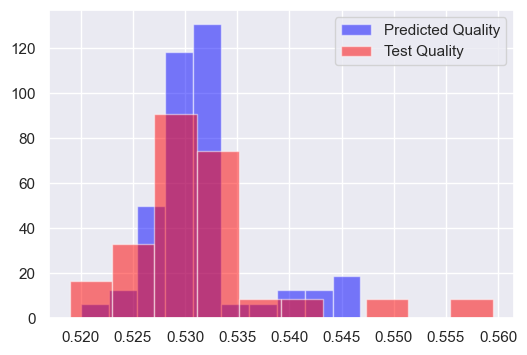

In [22]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

sns.set(font_scale=1.0)
plt.figure(figsize=(6,4))
plt.grid(True)
plt.hist(prediction['Quality'],density=True,label='Predicted Quality',color='blue',alpha=0.5)
plt.hist(y_test,density=True,label='Test Quality',color='red',alpha=0.5)
plt.legend()